In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from time import gmtime, strftime

Data Loader Class

In [2]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        face_1, face_2 = sample['face_1'], sample['face_2']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        face_1 = transform.resize(face_1, (128, 128))
        face_2 = transform.resize(face_2, (128, 128))
        
        face_1 = face_1.transpose((2, 0, 1))
        face_2 = face_2.transpose((2, 0, 1))
        label=torch.LongTensor(1, 1).zero_()
        label=sample['label']
        return {'face_1': torch.from_numpy(face_1),
                'face_2': torch.from_numpy(face_2),
                 'label':label
               }
trans = transforms.Compose([ToTensor()])

class FacePairsDataset(Dataset):
    """Face Pairs dataset."""

    def __init__(self, txt_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data=pd.read_csv(txt_file,header=None)
        df=data[0].str[:].str.split(' ', expand=True)
        df.columns = ["face_1", "face_2", "label"]
        self.face_pair_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.face_pair_frame)

    def __getitem__(self, idx):
        img_name_1 = os.path.join(self.root_dir, self.face_pair_frame.loc[idx, 'face_1'])
        img_name_2 = os.path.join(self.root_dir, self.face_pair_frame.loc[idx, 'face_2'])
        face_1 = io.imread(img_name_1)
        face_2 = io.imread(img_name_2)
        label=self.face_pair_frame.loc[idx,'label']
        label=int(label)
        sample = {'face_1': face_1,'face_2':face_2,'label': label}

        if self.transform:
            
            sample = self.transform(sample)

        return sample



Loads and transforms the data

In [3]:
trans = transforms.Compose([ToTensor()])

face_train_dataset = FacePairsDataset(txt_file='train.txt',root_dir='lfw/',transform=trans)
face_test_dataset = FacePairsDataset(txt_file='test.txt',root_dir='lfw/',transform=trans)

N = 8
train_loader = DataLoader(dataset=face_train_dataset, batch_size=N, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=face_test_dataset, batch_size=N, shuffle=False, num_workers=2)

tester code for batch loading

/home/jawa/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jawa/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0
1
2
3
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8])


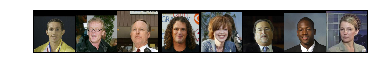

In [4]:
def show_faces_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    faces_1_batch, faces_2_batch = sample_batched['face_1'], sample_batched['face_2']
    print (faces_1_batch.shape)
    print (faces_2_batch.shape)
    labels_batch=sample_batched['label']
    print(labels_batch.shape)
    batch_size = len(faces_1_batch)
    im_size = faces_1_batch.size(2)
    grid_1 = utils.make_grid(faces_1_batch)
    grid_2 = utils.make_grid(faces_2_batch)
    plt.imshow(grid_1.numpy().transpose((1, 2, 0)))
    plt.imshow(grid_2.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(train_loader):
    print (i_batch)
    # sample_batched['face_1'].size() + sample_batched['face_2'].size()
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_faces_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
i=0

# Model C

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5,padding=2,stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,padding=2,stride=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1,stride=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1,stride=1)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(131072, 1024)
        

    def forward_once(self, x):
        # Max pooling over a (2, 2) window
        b_64 = nn.BatchNorm2d(64)
        b_128 = nn.BatchNorm2d(128)
        b_256 = nn.BatchNorm2d(256)
        b_512 = nn.BatchNorm2d(512)
        b_1024 = nn.BatchNorm2d(1024)
        
        #1,2,3,4
        x = F.relu(self.conv1(x))
        x = b_64(x)
        x = F.max_pool2d(x,2)
        
        #5,6,7,8
        x = F.relu(self.conv2(x))
        x = b_128(x)
        x = F.max_pool2d(x, 2)
        
        #9,10,11,12
        x = F.relu(self.conv3(x))
        x = b_256(x)
        x = F.max_pool2d(x,2)
        
        #13,14,15 (no max pooling)
        x = F.relu(self.conv4(x))
        x=b_512(x)
        
        # 16
        x = x.view(-1, self.num_flat_features(x))
        
        #17,18,19
        x = F.relu(self.fc1(x))
        x= b_1024(x)
        
        return x
    
    def forward(self,input1,input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features




# Siamese_Net Rewrite below function

In [6]:

class Siamese_Net(torch.nn.Module):
    

    def __init__(self):
        super(Siamese_Net, self).__init__()
        self.net = Net()
        self.fc = nn.Linear(2048, 1)


    def forward(self, input1, input2):
        output_1,output_2=self.net(input1,input2)
      
        x = torch.cat((output_1,output_2), 1)
        m = nn.Sigmoid()
        output = m(self.fc(x))
        return output
    


# Sanity Checks for parameters

In [7]:
snet=Siamese_Net()
params = list(snet.parameters())
print(len(params))
print(params[0].size())  # bases weight
print(params[2].size())  # conv2's .weight
print(params[4].size())  # conv3's .weight
print(params[6].size())  # conv4's .weight
print(params[8].size())  # conv5's .weight
print(params[10].size())  # linear 2 .weight


12
torch.Size([64, 3, 5, 5])
torch.Size([128, 64, 5, 5])
torch.Size([256, 128, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([1024, 131072])
torch.Size([1, 2048])


# Optimizer, Loss

In [8]:
# i=1
# input_1 = Variable(face_train_dataset[i]['face_1'].unsqueeze(0).float())
# input_2 = Variable(face_train_dataset[i]['face_2'].unsqueeze(0).float())
# p = snet(input_1,input_2)
# print(p)
net_2 = Net()
snet_3= Siamese_Net()
a = torch.randn(2,3,128,128)
b = torch.randn(2,3,128,128)

p,q=net_2(Variable(a.cuda()),Variable(b.cuda()))
# print(p.size())


temp=snet_3(Variable(a.cuda()),Variable(b.cuda()))

x = torch.cat((a,b), 1)
print(x.shape)

RuntimeError: tensors are on different GPUs

In [9]:
import torch.optim as optim

snet = Siamese_Net().cuda()
print(snet)
criterion = nn.BCELoss().cuda()
optimizer = optim.SGD(snet.parameters(), lr=0.001, momentum=0.9)


Siamese_Net (
  (net): Net (
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear (131072 -> 1024)
  )
  (fc): Linear (2048 -> 1)
)


In [10]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0
    for i, sample_batched in enumerate(train_loader):
        # get the inputs
        faces_1_batch, faces_2_batch = sample_batched['face_1'], sample_batched['face_2']
        labels_batch = sample_batched['label']
        
        # wrap them in Variable
        faces_1_batch=faces_1_batch.float()
        faces_2_batch=faces_2_batch.float()
        input1,input2 = Variable(faces_1_batch.cuda()),Variable(faces_2_batch.cuda())
        labels_batch=labels_batch.float()
        labels_batch = Variable(labels_batch.cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = snet(input1,input2)
#         print("outputs size")
#         print (outputs.size())
        outputs_flat=outputs.view(outputs.numel()).float()
#         print(outputs_flat)
#         print(labels_batch)
        loss = criterion(outputs_flat, labels_batch)
        loss.backward()
        optimizer.step()

print('Finished Training')


/home/jawa/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jawa/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


RuntimeError: std::bad_cast

In [ ]:
curr_time=strftime("%Y-%m-%d %H:%M:%S", gmtime())
save_file_path='snet_basic_'+curr_time
torch.save(snet.state_dict(), save_file_path)

In [ ]:
correct = 0
total = 0
count=0
snet_load = Siamese_Net()
snet_load.load_state_dict(torch.load('snet_save'))
for data in test_loader:
    count=count+1
    faces_1_batch, faces_2_batch = sample_batched['face_1'], sample_batched['face_2']
    labels_batch = sample_batched['label']
    
    input1,input2 = Variable(faces_1_batch),Variable(faces_2_batch)
    outputs = snet_load(input_1,input_2)
    
    predicted = torch.sign(torch.sign(outputs.data-0.5))
    total += labels_batch.size(0)
    correct += (predicted.long() == labels_batch.long()).sum()

ac=100 * (correct / total)
print('Accuracy of the network on the 10000 test images: %d %%' % ac)